# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Import the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import tensorflow as tf

### Change directory

In [3]:
import os

In [4]:
os.chdir("/content/drive/My Drive/CNN/Internal lab/")

### Load the training data from train.csv file

In [5]:
train_data=pd.read_csv("train_labels.csv")

### Print the shape of the train dataset

In [6]:
train_data.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [7]:
IMAGE_SIZE = 128

In [8]:
!pip install rarfile

In [9]:
!pip install unrar

In [10]:
import rarfile

In [11]:
#images_zip_path = 'images_racoon.rar'
#with rarfile.RarFile(images_zip_path) as rf:
#    rf.extractall()


### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [12]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height


In [13]:
coords.shape

(173, 4)

In [14]:
len(paths)

173

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [15]:
from PIL import Image

In [16]:
path = "/content/drive/My Drive/CNN/Internal lab/images/images/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 200
raccoon-1.jpg


In [17]:
import cv2
batch_images = []

for file in files:
    image = cv2.imread(path+file,1)
    image = cv2.resize(image,dsize=(128,128))
    image = image.reshape((image.shape[0],image.shape[1],3))
    batch_images.append(image)


In [18]:
from tensorflow.keras.applications.mobilenet import preprocess_input

batch_images = preprocess_input(np.array(batch_images, dtype=np.float32))
print (batch_images.shape)

(200, 128, 128, 3)


In [19]:
batch_images=batch_images[0:173,]
print(batch_images.shape)

(173, 128, 128, 3)


### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import  MobileNet
from tensorflow.keras.layers import Conv2D, Reshape

In [21]:
model = MobileNet(input_shape=(128, 128, 3), include_top=False) 
for layer in model.layers:
    layer.trainable = False
model1 = model.layers[-1].output
model1 = Conv2D(4, kernel_size=4)(model1)
model1 = Reshape((4,))(model1)

myModel = Model(inputs=model.input,outputs = model1)

### Define a custom loss function IoU which calculates Intersection Over Union

In [22]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

In [23]:
from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [30]:
from keras.optimizers import Adam
from keras.backend import epsilon

optimizer = Adam(lr=0.01)
myModel.compile(optimizer = optimizer , loss = "mse", metrics=[IoU]) 
myModel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

In [31]:
batch_size = 32
nb_epochs = 30
history1 = myModel.fit(batch_images,
                       coords,
                       batch_size=batch_size,
                       epochs=nb_epochs,
                       verbose = 1)

Epoch 1/30
6/6 [==============================] - 2s 303ms/step - loss: 3483.6211 - IoU: 0.1562
Epoch 2/30
6/6 [==============================] - 2s 298ms/step - loss: 1541.2045 - IoU: 0.3428
Epoch 3/30
6/6 [==============================] - 2s 296ms/step - loss: 1199.3704 - IoU: 0.3552
Epoch 4/30
6/6 [==============================] - 2s 302ms/step - loss: 855.2344 - IoU: 0.4517
Epoch 5/30
6/6 [==============================] - 2s 295ms/step - loss: 515.0535 - IoU: 0.5164
Epoch 6/30
6/6 [==============================] - 2s 298ms/step - loss: 363.8172 - IoU: 0.5527
Epoch 7/30
6/6 [==============================] - 2s 299ms/step - loss: 218.3974 - IoU: 0.6132
Epoch 8/30
6/6 [==============================] - 2s 293ms/step - loss: 181.8777 - IoU: 0.6399
Epoch 9/30
6/6 [==============================] - 2s 293ms/step - loss: 123.4707 - IoU: 0.6822
Epoch 10/30
6/6 [==============================] - 2s 291ms/step - loss: 84.0208 - IoU: 0.7388
Epoch 11/30
6/6 [==============================

### Pick a test image from the given data

In [53]:
test_img = '/content/drive/My Drive/CNN/Internal lab/images/raccoon-1.jpg'
print(test_img)
unscaled = cv2.imread(test_img)

/content/drive/My Drive/CNN/Internal lab/images/raccoon-1.jpg


In [54]:
print(unscaled)

[[[227 207 202]
  [225 205 200]
  [223 203 198]
  ...
  [ 74  71  73]
  [ 66  65  67]
  [ 70  69  71]]

 [[225 205 200]
  [223 203 198]
  [221 201 196]
  ...
  [ 69  66  68]
  [ 59  58  60]
  [ 64  63  65]]

 [[223 203 198]
  [222 202 197]
  [220 200 195]
  ...
  [ 73  70  72]
  [ 60  59  63]
  [ 65  64  68]]

 ...

 [[152 138 142]
  [139 125 129]
  [146 132 136]
  ...
  [102  95 102]
  [ 80  75  84]
  [ 90  85  94]]

 [[166 152 156]
  [136 122 126]
  [135 121 125]
  ...
  [129 118 126]
  [112 103 113]
  [122 113 123]]

 [[178 169 179]
  [164 155 165]
  [164 153 163]
  ...
  [102  97  99]
  [ 96  92  98]
  [111 107 113]]]


### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [55]:
image_height, image_width, chnl = unscaled.shape

In [57]:
image = cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image,dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [58]:
region = myModel.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

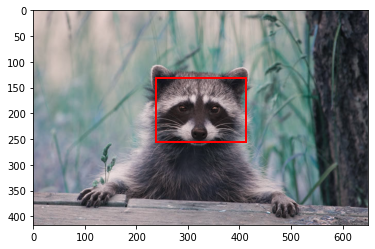

In [59]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()